<a href="https://colab.research.google.com/github/theonlyworld/DeepLearningWithPython/blob/main/DL1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels),(test_images, test_labels) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [2]:
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])

In [3]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [4]:
train_images = train_images.reshape((60000, 28*28))
train_images = train_images.astype("float32")/255
test_images = test_images.reshape((10000, 28*28))
test_images = test_images.astype("float32")/255

In [5]:
model.fit(train_images, train_labels, epochs=5, batch_size=128)

Epoch 1/5
469/469 [==============================] - 3s 6ms/step - loss: 0.2645 - accuracy: 0.9243
Epoch 2/5
469/469 [==============================] - 3s 7ms/step - loss: 0.1087 - accuracy: 0.9687
Epoch 3/5
469/469 [==============================] - 3s 6ms/step - loss: 0.0699 - accuracy: 0.9792
Epoch 4/5
469/469 [==============================] - 3s 6ms/step - loss: 0.0505 - accuracy: 0.9851
Epoch 5/5
469/469 [==============================] - 3s 6ms/step - loss: 0.0383 - accuracy: 0.9883


In [6]:
test_digits = test_images[0:10]
predictions = model.predict(test_digits)
predictions[0]

1/1 [==============================] - 0s 88ms/step


array([2.2069452e-08, 1.2422749e-08, 8.3504783e-06, 3.4554418e-05,
       7.4765763e-11, 3.1149807e-07, 2.8338073e-11, 9.9994928e-01,
       2.3177486e-07, 7.1183958e-06], dtype=float32)

In [7]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"test_acc: {test_acc}")

313/313 [==============================] - 1s 1ms/step - loss: 0.0699 - accuracy: 0.9781
test_acc: 0.9781000018119812


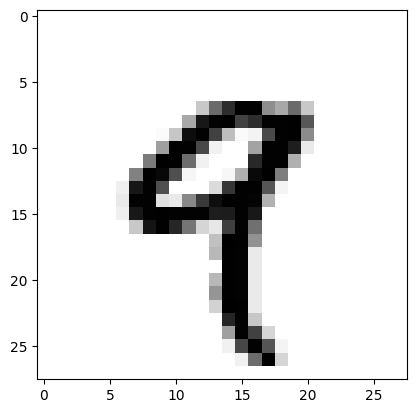

In [13]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels),(test_images, test_labels) = mnist.load_data()

import matplotlib.pyplot as plt
digit = train_images[4]
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

In [15]:
train_images[4]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  